I donwloaded recent water level observations from this website.
http://www.pac.dfo-mpo.gc.ca/science/charts-cartes/obs-app/observed-eng.aspx?StationID=07795

For comparison with nowcast or forecast.

In [1]:
import pandas as pd
from dateutil import tz
import datetime
import numpy as np
import os
import netCDF4 as nc
import matplotlib.pyplot as plt

from nowcast import figures, analyze
%matplotlib inline

In [2]:
def dateparse(s):
    """Function to make datetime object aware of time zone
    e.g. date_parser=dateParserMeasured('2014-05-31 11:42')

    :arg s: string of date and time
    :type s: str

    :returns: datetime object that is timezone aware
    """
    PST_tz = tz.tzoffset("PST", -28800)
    # Convert the string to a datetime object
    unaware = datetime.datetime.strptime(s, "%Y-%m-%d %H:%M")
    # Add in the local time zone (Canada/Pacific)
    aware = unaware.replace(tzinfo=PST_tz)
    # Convert to UTC
    return aware.astimezone(tz.tzutc())

In [3]:
data = pd.read_csv('PA_Dec.csv',parse_dates=[1],date_parser=dateparse)
data=data.rename(columns={'TIME_TAG PST (Z+8)': 'time'})
series = pd.Series(np.array(data['ENCODER2']), index = data['time'])
series=series.resample('15T')

In [4]:
nowcast = '/results/SalishSea/nowcast/'
location = 'PointAtkinson'
tides_path = '/data/nsoontie/MEOPAR/tools/SalishSeaNowcast/nowcast/tidal_predictions/'
grid={}
sdt = datetime.datetime(2015,12,2)
edt = datetime.datetime(2015,12,11)

numdays = (edt-sdt).total_seconds()/86400
dates = [sdt + datetime.timedelta(days=d) for d in np.arange(numdays+1) ]

ssh = np.array([])
time = np.array([])
for d in dates:
    fname = os.path.join(nowcast, d.strftime('%d%b%y').lower(), '{}.nc'.format(location))
    grid = nc.Dataset(fname)
    s,t = figures.load_model_ssh(grid)
    ssh=np.append(ssh,s)
    time=np.append(time,t)
tides = figures.get_tides('Point Atkinson',path=tides_path)
ssh_corr = figures.correct_model_ssh(ssh, time,tides )

## compare water levels - observed, model, tides

(735934.0, 735943.0)

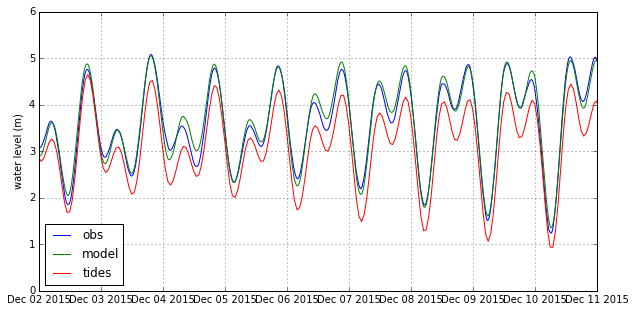

In [5]:
fig,ax=plt.subplots(1,1,figsize=(10,5))
ax.plot(series.index, series, label='obs')
ax.plot(time,ssh_corr+figures.SITES['Point Atkinson']['msl'], label='model')
ax.plot(tides.time, tides.pred_all + figures.SITES['Point Atkinson']['msl'], label='tides')
ax.set_ylabel('water level (m)')
ax.grid()
ax.legend(loc=0)
ax.set_xlim([sdt,edt])

This looks reasonable

## compare residuals - observed, modelled

In [6]:
obs_interp = figures.interp_to_model_time(time, series, series.index)
obs_interp = np.array(obs_interp) - figures.SITES['Point Atkinson']['msl']

model_res =figures.compute_residual(ssh_corr, time, tides)
obs_res = figures.compute_residual(obs_interp, time, tides)

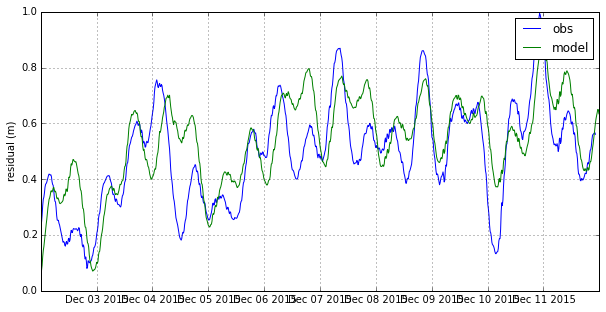

In [7]:
fig,ax=plt.subplots(1,1,figsize=(10,5))
ax.plot(time, obs_res, label='obs')
ax.plot(time, model_res, label='model')
ax.set_ylabel('residual (m)')
ax.grid()
ax.legend()

There is a very clear semi-diurnal signal in both the observed residual and the model residual. This doesn't happen for the residuals on the DFO website. Is it my tides? I'm using CHS constituents... Did I do something wrong?

## compare my tides and DFO tides

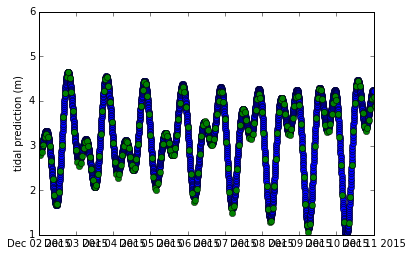

In [8]:
plt.plot(data.time, data.PREDICTION,'o')
plt.plot(tides.time, tides.pred_all+figures.SITES['Point Atkinson']['msl'], 'o')
plt.axis([sdt,edt,1,6])
plt.ylabel('tidal prediction (m)')

In [9]:
tide_nonan = data[~np.isnan(data.PREDICTION)]
tide_interp = figures.interp_to_model_time(time,tide_nonan.PREDICTION, tide_nonan.time)

ttide_interp = figures.interp_to_model_time(time, tides.pred_all, tides.time)
diff = np.array(tide_interp) - (np.array(ttide_interp)+figures.SITES['Point Atkinson']['msl'])

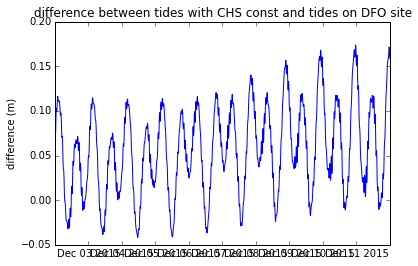

In [10]:
plt.plot(time, diff)
plt.ylabel('difference (m)')
plt.title('difference between tides with CHS const and tides on DFO site')

There it is again. For some reason the tides I calculate with CHS constituents have some semi-diurnal energy not present in the DFO tides.

## New tides
Redo tidal predictions. Don't use CHS constituents. Use ones from a harominc analysis with t_tide.

Harmonics from analysing 2008 time series

In [11]:
tides2 = figures.get_tides('Point Atkinson',path='/data/nsoontie/MEOPAR/analysis/storm_surges/data/')
obs_res2 = figures.compute_residual(obs_interp, time, tides2)

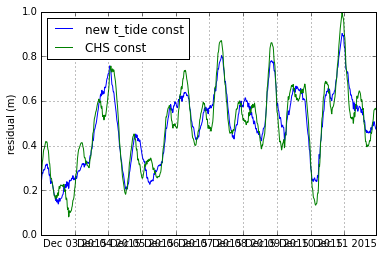

In [12]:
plt.plot(time,obs_res2, label = 'new t_tide const')
plt.plot(time, obs_res, label = 'CHS const')
plt.legend(loc=0)
plt.grid()
plt.ylabel('residual (m)')

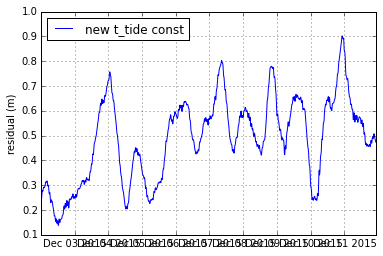

In [13]:
plt.plot(time,obs_res2, label = 'new t_tide const')
plt.grid()
plt.ylabel('residual (m)')
plt.legend(loc=0)

There is still some semi-dirunal, but not nearly as much as the green line above


## Redo model residuals and compare with observed

In [14]:
ssh_corr2 = figures.correct_model_ssh(ssh, time,tides2 )
model_res2 =figures.compute_residual(ssh_corr2, time, tides2)

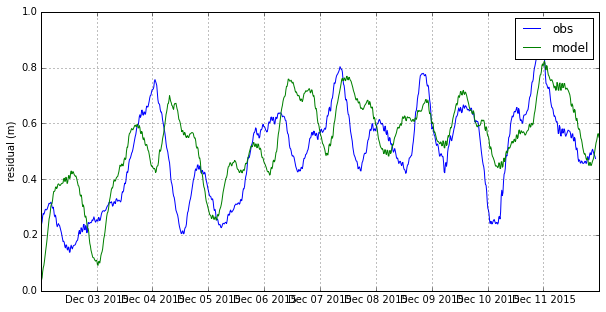

In [15]:
fig,ax=plt.subplots(1,1,figsize=(10,5))
ax.plot(time, obs_res2, label='obs')
ax.plot(time, model_res2, label='model')
ax.set_ylabel('residual (m)')
ax.grid()
ax.legend()

Residuals aren't the best. Looks like we have a phase problem for some of these events. Note that our model tides aren't perfect so there are some issues with using a tidal prediction to calclate the residual. I don't know how to quantify that error. Maybe I could do a harmonic analysis on a year long time series of water levels at each station. That would give me an idea of our model's tides..

But, given the residual problems, we are doing pretty good for the water level. (Below)

(735934.0, 735943.0)

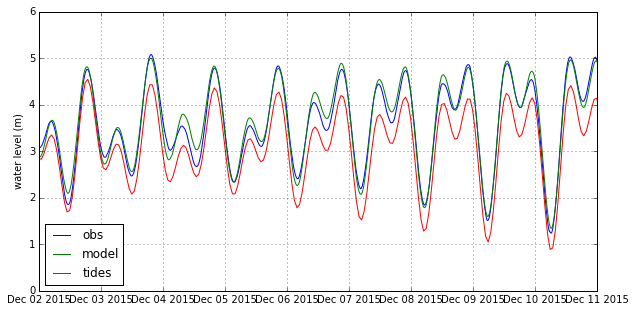

In [16]:
fig,ax=plt.subplots(1,1,figsize=(10,5))
ax.plot(series.index, series, label='obs')
ax.plot(time,ssh_corr2+figures.SITES['Point Atkinson']['msl'], label='model')
ax.plot(tides2.time, tides2.pred_all + figures.SITES['Point Atkinson']['msl'], label='tides')
ax.set_ylabel('water level (m)')
ax.grid()
ax.legend(loc=0)
ax.set_xlim([sdt,edt])

I'd like to hold off on the error analysis until I have an automated way of getting observations for more of the stations.

How important are the residuals in our plotting? It would be nice to not have such a strong semi-dirunal signal. It would be as easy as replacing the tides file with the new one I calculated. 

But I haven't looked at any of the other stations in detail and don't really know how well the CHS constituents remove all the tidal energy... think it would be easiest to do the same thing for every station. 

# Forecasts

In [17]:
nowcast = '/results/SalishSea/forecast/'
location = 'PointAtkinson'
grid={}
numdays = (edt-sdt).total_seconds()/86400
dates = [sdt + datetime.timedelta(days=d) for d in np.arange(numdays+1) ]

ssh_forecast = np.array([])
time_forecast = np.array([])
for d in dates:
    fname = os.path.join(nowcast, d.strftime('%d%b%y').lower(), '{}.nc'.format(location))
    grid = nc.Dataset(fname)
    s,t = figures.load_model_ssh(grid)
    s_sub = s[0:96] #subsample for just one day
    t_sub = t[0:96]
    ssh_forecast=np.append(ssh_forecast,s_sub)
    time_forecast=np.append(time_forecast,t_sub)
ssh_corr_forecast = figures.correct_model_ssh(ssh_forecast, time_forecast,tides2 )
model_res_forecast =figures.compute_residual(ssh_corr_forecast, time_forecast, tides2)

(735934.0, 735943.0)

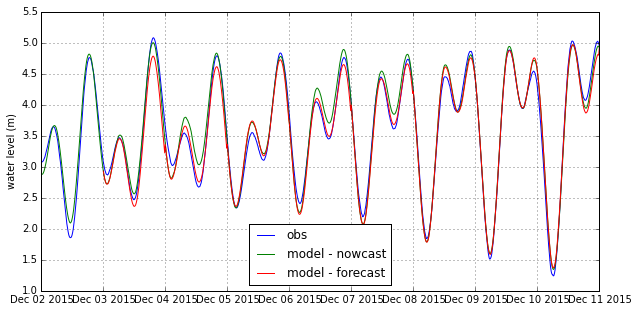

In [18]:
fig,ax=plt.subplots(1,1,figsize=(10,5))
ax.plot(series.index, series, label='obs')
ax.plot(time,ssh_corr2+figures.SITES['Point Atkinson']['msl'], label='model - nowcast')
ax.plot(time_forecast,ssh_corr_forecast+figures.SITES['Point Atkinson']['msl'], label='model - forecast')
ax.set_ylabel('water level (m)')
ax.grid()
ax.legend(loc=0)
ax.set_xlim([sdt,edt])

Only first 24 hours of forecast

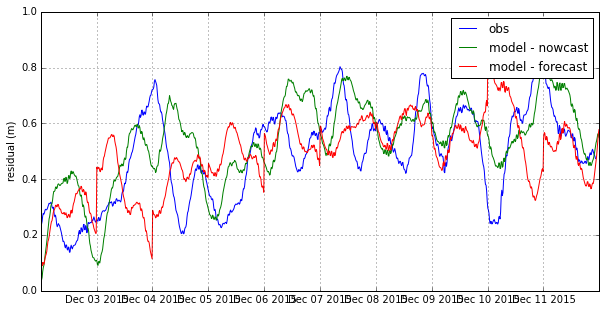

In [19]:
fig,ax=plt.subplots(1,1,figsize=(10,5))
ax.plot(time, obs_res2, label='obs')
ax.plot(time, model_res2, label='model - nowcast')
ax.plot(time, model_res_forecast, label='model - forecast')
ax.set_ylabel('residual (m)')
ax.grid()
ax.legend()

Discontinuties in forecast residual because of truncating to one day. 